In [1]:
# %pip install tensorflow_probability 

# CNN + GM
Combinar los dos approaches es bastante caro, 10 minutos por epoca, me daba unas 5 horas de trainiing con solo 1000 datos


In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt


datos


In [3]:
# 02_main.ipynb
from grav_lens import get_datasets
from grav_lens.models import test_model_image

import os 

home_data = os.path.join("..","data")
train_dataset, val_dataset, test_dataset = get_datasets(data_index='1', max_files=1500, 
    home=home_data)

import matplotlib.pyplot as plt
import numpy as np


def plot_history(history):
	# Crear una figura
	plt.figure(figsize=(12, 8))

	line_styles = ['-', '--', '-.', ':']
	for i, key in enumerate(history.history.keys()):
		plt.plot(history.history[key], label=key, linestyle=line_styles[i % len(line_styles)])  # Estilo de línea diferente

	plt.yscale('log')
	# Configurar los detalles de la gráfica
	plt.title('Evolución de las Pérdidas y Métricas durante el Entrenamiento')
	plt.xlabel('Épocas')
	plt.ylabel('Valor')
	plt.legend()
	plt.grid(True)
	plt.show()


Using data folder: ..\data\1


Modelo Gaussiano
Toma los parametros y construye la imagen

In [4]:
class GaussianImageLayer(tf.keras.layers.Layer):
    def __init__(self, img_size=64, Ng=10, sigma_penalty_weight=0.01, c_pi_penalty_weight=0.01, **kwargs):
        super(GaussianImageLayer, self).__init__(**kwargs) 
        self.img_size = img_size  # Tamaño de la imagen generada
        self.Ng = Ng  # Número de Gaussianas
        self.sigma_penalty_weight = sigma_penalty_weight  # Peso de la penalización sobre sigma
        self.c_pi_penalty_weight = c_pi_penalty_weight  # Peso de la penalización sobre c_pi

    def call(self, flat_tensor):
        """Construcción de la imagen con múltiples Gaussianas a partir del tensor plano."""
        batch_size = tf.shape(flat_tensor)[0]
        
        # Ahora Ng es un parámetro fijo pasado al constructor
        Ng = self.Ng

        # Extraer c_pi, mu_x, mu_y, sigma_x, sigma_y
        c_pi = flat_tensor[:, :Ng]  # Coeficientes de mezcla
        mu_x = flat_tensor[:, Ng:2*Ng]  # Media en x
        mu_y = flat_tensor[:, 2*Ng:3*Ng]  # Media en y
        sigma_x = tf.abs(flat_tensor[:, 3*Ng:4*Ng]) + 0.1  # Desviación estándar en x (mínimo de 0.1)
        sigma_y = tf.abs(flat_tensor[:, 4*Ng:]) + 0.1  # Desviación estándar en y (mínimo de 0.1)

        # Añadir penalización de sigma en la loss (L2 regularization para mantener los valores pequeños)
        self.add_loss(self.sigma_penalty_weight * tf.reduce_sum(tf.square(sigma_x) + tf.square(sigma_y)))

        # Añadir penalización de c_pi en la loss (L2 regularization para mantener los valores de c_pi cercanos a 0)
        self.add_loss(self.c_pi_penalty_weight * tf.reduce_sum(tf.square(c_pi)))

        # Normalizar mu_x y mu_y al rango de la grilla [-1, 1]
        mu_x = mu_x * 2 - 1  # Transformar de [0, 1] a [-1, 1]
        mu_y = mu_y * 2 - 1  # Transformar de [0, 1] a [-1, 1]

        # Crear una grilla de coordenadas (img_size x img_size)
        x = tf.linspace(-1.0, 1.0, self.img_size)
        y = tf.linspace(-1.0, 1.0, self.img_size)
        X, Y = tf.meshgrid(x, y)  # Crear grilla de coordenadas
        coords = tf.stack([X, Y], axis=-1)  # Combinar coordenadas (img_size, img_size, 2)

        # Expandir dimensiones para batch y Ng
        coords = tf.reshape(coords, (1, self.img_size, self.img_size, 2))  # (1, img_size, img_size, 2)
        coords = tf.tile(coords, [batch_size, 1, 1, 1])  # (batch_size, img_size, img_size, 2)

        # Inicializar la imagen final en ceros
        final_image = tf.zeros((batch_size, self.img_size, self.img_size), dtype=tf.float32)

        # Iterar sobre el número de Gaussianas (Ng)
        for i in range(Ng):
            # Obtener las medias y desviaciones para la Gaussiana i
            mu = tf.stack([mu_x[:, i], mu_y[:, i]], axis=-1)  # (batch_size, 2)
            sigma = tf.stack([sigma_x[:, i], sigma_y[:, i]], axis=-1)  # (batch_size, 2)

            # Expandir las dimensiones de mu y sigma para que coincidan con las coordenadas de la imagen
            mu = tf.expand_dims(mu, axis=1)  # (batch_size, 1, 2)
            mu = tf.expand_dims(mu, axis=1)  # (batch_size, 1, 1, 2)
            sigma = tf.expand_dims(sigma, axis=1)  # (batch_size, 1, 2)
            sigma = tf.expand_dims(sigma, axis=1)  # (batch_size, 1, 1, 2)

            # Crear una distribución normal multivariada para cada batch y Gaussiana
            mvn = tfp.distributions.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
            
            # Calcular las probabilidades en las coordenadas de la imagen
            gaussians = mvn.prob(coords)  # (batch_size, img_size, img_size)
            
            # Ponderar cada Gaussiana por c_pi (ajustar dimensiones para que coincidan)
            gaussians_weighted = gaussians * tf.expand_dims(tf.expand_dims(c_pi[:, i], axis=-1), axis=-1)

            # Sumar la Gaussiana ponderada a la imagen final
            final_image += gaussians_weighted

        # Expandir las dimensiones de la imagen final para que sea (batch_size, img_size, img_size, 1)
        return tf.expand_dims(final_image, axis=-1)

    def compute_output_shape(self, input_shape):
        # Definir la forma de salida, que será (batch_size, img_size, img_size, 1)
        return (input_shape[0], self.img_size, self.img_size, 1)


# Construccion del modelo

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models
from grav_lens import metrics

def create_cnn_model(hyperparams):
	"""
	Función para construir un modelo CNN secuencial con hiperparámetros ajustables a través de un diccionario.
	
	Parámetros:
	- hyperparams: Diccionario con los hiperparámetros del modelo.
	
	Retorna:
	- Un modelo CNN construido con los hiperparámetros especificados.
	"""
	
	img_size = hyperparams['img_size']
	Ng = hyperparams['Ng']
	num_conv_layers = hyperparams['num_conv_layers']
	conv_filters = hyperparams['conv_filters']
	kernel_size = hyperparams['kernel_size']
	dense_units = hyperparams['dense_units']
	num_dense_layers = hyperparams['num_dense_layers']
	activation = hyperparams['activation']
	output_activation = hyperparams['output_activation']
	learning_rate = hyperparams['learning_rate']
	

	input_layer = tf.keras.layers.Input(shape=(128, 128, 3))
	initializer = tf.keras.initializers.GlorotNormal()

	# Branch de Parametros ---------------------
	x = layers.Conv2D(conv_filters, kernel_size, 
		activation=activation, padding='same', kernel_initializer=initializer)(input_layer)
	# Capas convolucionales hidden 
	for _ in range(num_conv_layers):
		x = layers.Conv2D(conv_filters*4, kernel_size, 
			activation=activation, padding='same', kernel_initializer=initializer)(x)
		x = layers.MaxPooling2D(pool_size=(2, 2))(x)

	# Densas
	x = layers.Flatten()(x)
	for _ in range(num_dense_layers):
		x = layers.Dense(dense_units, activation=activation, kernel_initializer=initializer)(x)
	
	# Capa de salida para generar el vector plano
	output_units = 5 * Ng  # 5 parámetros por cada Gaussiana
	x = layers.Dense(output_units, activation=output_activation, kernel_initializer=initializer)(x)
	out_img_g = GaussianImageLayer(img_size=128, Ng=Ng)(x)

	# CNN ---------------------------
	x_cnn = tf.keras.layers.Conv2D(32, (3, 3), activation="sigmoid", padding='same')(input_layer)

	x_cnn = tf.keras.layers.UpSampling2D(size=(2, 2))(x_cnn) # 256, 256
	x_cnn = tf.keras.layers.Conv2D(conv_filters, kernel_size, activation="sigmoid", padding='same')(x_cnn)

	x_cnn = tf.keras.layers.BatchNormalization()(x_cnn)
	x_cnn = tf.keras.layers.Conv2D(2 * conv_filters, kernel_size, activation="sigmoid", padding='same')(x_cnn)

	x_cnn = tf.keras.layers.BatchNormalization()(x_cnn)
	x_cnn = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x_cnn) # 128x_cnn128
	x_cnn = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding='same')(x_cnn)
	out_img_cnn = tf.keras.layers.BatchNormalization()(x_cnn)
	# --------------

	output_image = out_img_g + out_img_cnn

	output_image = tf.keras.layers.Conv2D(1, (1,1), activation="tanh", padding='same', name='out_img')(output_image)

	
	model = tf.keras.models.Model(inputs=input_layer, 
		outputs=[output_image, output_image, output_image] )

	optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)


	model.compile(optimizer=optimizer, 
				loss= ['mse', metrics.WMAPE, 'mae'],
				metrics={'out_img': [metrics.DICEE, metrics.WMAPE]})


	return model


# Crear el modelo

In [16]:

# Hiperparámetros como un diccionario
hyperparams = {
	'img_size': 128,               # Tamaño de la imagen de entrada
	'Ng': 10,                     # Número de Gaussianas (esto afecta el tamaño de salida)
	'num_conv_layers': 4,         # Número de capas convolucionales
	'conv_filters': 32,           # Número de filtros en cada capa convolucional
	'kernel_size': (3, 3),        # Tamaño del kernel
	'dense_units': 128,           # Número de unidades en las capas densas
	'num_dense_layers': 2,        # Número de capas densas
	'activation': 'tanh',         # Función de activación en las capas
	'output_activation': 'sigmoid',    # Sin activación final (los valores pueden ser negativos o positivos)
	'learning_rate': 0.0001        # Tasa de aprendizaje
}

# Crear el modelo utilizando el diccionario de hiperparámetros
cnn_model = create_cnn_model(hyperparams)

## Training

In [17]:

history = cnn_model.fit(train_dataset, validation_data=val_dataset, epochs=30, verbose=True)


Epoch 1/30
     32/Unknown 413s 12s/step - loss: 1.9643 - out_img_dicee: 0.5829 - out_img_wmape: 193.7730

C:\Users\fbien.DESKTOP-6FMEAR7\Documents\python\lib\contextlib.py:135: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(type, value, traceback)


32/32 ━━━━━━━━━━━━━━━━━━━━ 458s 13s/step - loss: 1.9419 - out_img_dicee: 0.5817 - out_img_wmape: 192.4528 - val_loss: 0.7603 - val_out_img_dicee: 0.5278 - val_out_img_wmape: 149.1336
Epoch 2/30
 7/32 ━━━━━━━━━━━━━━━━━━━━ 4:29 11s/step - loss: 0.6055 - out_img_dicee: 0.5334 - out_img_wmape: 90.2188

KeyboardInterrupt: 

In [18]:
plot_history(history)

NameError: name 'history' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
(3, 128, 128, 1)


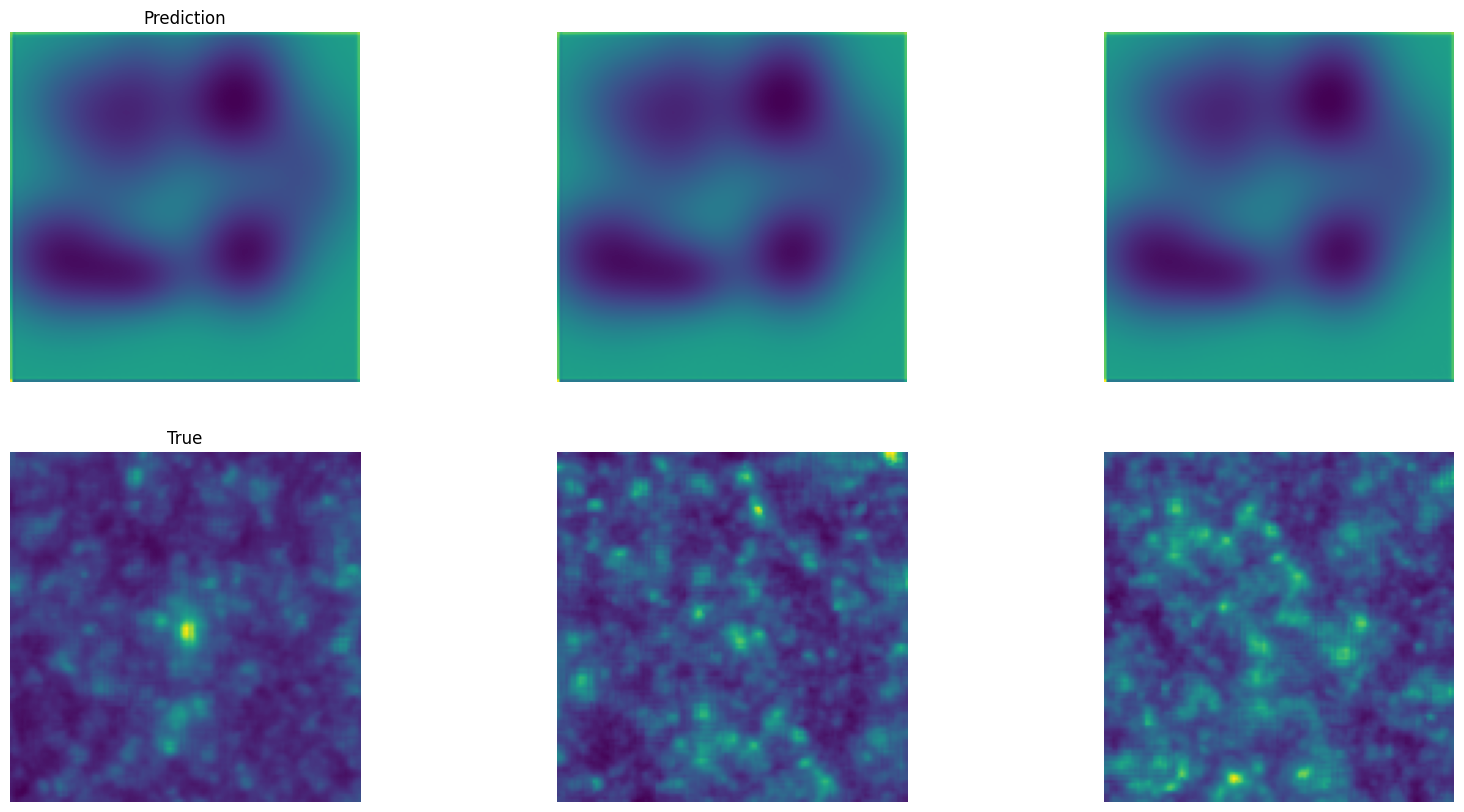

In [19]:
test_model_image(cnn_model, test_dataset, outs=2)